# **Part-of-Speech Tagging Using Hidden Markov Model (HMM)**  
## **AIM-829 Assignment 1**  

---

### Nishad Bagade (MT2024102)
### Rishabh Kumar Singh (MT2024125)
### Kuldeep Chamoli (MT2024081)
### Abhishek Kumar SIngh (MT2024006)

---

## **Objective**  
In this assignment, we will implement a **Part-of-Speech (PoS) tagging system** using a **Hidden Markov Model (HMM)**.  
The goal is to correctly tag words in sentences by leveraging the **Viterbi algorithm**.  

We will train and evaluate the model using the provided datasets, where each word is paired with its corresponding PoS tag.  

---

## **Dataset Details**  
We are provided with two datasets in **CSV format**:  

- **Training Set**: Contains sentences where each word is paired with its corresponding PoS tag in the format: `(word-tag)`.  
- **Test Set**: Also follows the same `(word-tag)` format and will be used to evaluate our model’s performance.  

Each row represents a **word and its tag**, grouped by sentences.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# When we read the CSV file using pandas.read_csv(), the entries remain as strings, not as actual tuples.
# To convert these strings into Python tuples, literal_eval() is used.
from ast import literal_eval

### **Step 1: Understanding the Dataset**
 

---

In [2]:
# Load Data

file_path = r"C:\Users\nisha\OneDrive\Desktop\Datasets\TRAIN - TRAIN.csv.csv"
file_path_test = r"C:\Users\nisha\OneDrive\Desktop\Datasets\TEST - TEST.csv.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at {file_path}")

if not os.path.exists(file_path_test):
    raise FileNotFoundError(f"File not found at {file_path_test}")

df = pd.read_csv(file_path, header=None, names=["data"])
df_test = pd.read_csv(file_path_test, header=None, names=["data"])

print("Data loaded...")
print(df.head())

Data loaded...
                                                data
0  [('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM...
1  [('The', 'DET'), ('industry', 'NOUN'), ('has',...
2  [('Love', 'VERB'), ('this', 'DET'), ('place', ...
3  [('This', 'DET'), ('problem', 'NOUN'), ('of', ...
4  [('Esso', 'PROPN'), ('said', 'VERB'), ('0', 'X...


### **Step 2: Preprocessing**


---

In [3]:
def parse_row(row):
    if isinstance(row, str):
        return literal_eval(row)
    return []

# Convert string representations to actual tuples
df["processed"] = df["data"].apply(parse_row)
df_test["processed"] = df_test["data"].apply(parse_row)

In [4]:
# Split into sentences and tags

sentences = []
tags = []

for row in df["processed"]:
    words = [word for word, tag in row]
    tag_sequence = [tag for word, tag in row]
    sentences.append(words)
    tags.append(tag_sequence)

print(f"\nTotal sentences processed: {len(sentences)}")


Total sentences processed: 52499


In [5]:
# For Testing
# Split into sentences and tags

sentences_test = []
tags_test = []

for row in df_test["processed"]:
    words = [word for word, tag in row]
    tag_sequence = [tag for word, tag in row]
    sentences_test.append(words)
    tags_test.append(tag_sequence)

print(f"\nTotal sentences processed: {len(sentences_test)}")


Total sentences processed: 65624


In [6]:
# Define Train/Test

train_sentences = sentences[:]
train_tags = tags[:]
test_sentences = sentences_test[:]
test_tags = tags_test[:]

### **Step 3: Estimate HMM Parameters using the Training Set**
1. **Transition Probability**: The probability of transitioning from one tag to another.  
2. **Emission Probability**: The probability of a word being associated with a particular tag.  
3. **Initial Probability**: The probability of a tag appearing at the start of a sentence.  

Mathematically, these probabilities are estimated as follows:

- **Transition Probability**:  
  $$
  P(T_{i} | T_{i-1}) = \frac{\text{Count}(T_{i-1} \rightarrow T_{i})}{\text{Count}(T_{i-1})}
  $$

- **Emission Probability**:  
  $$
  P(W_{i} | T_{i}) = \frac{\text{Count}(T_{i} \rightarrow W_{i})}{\text{Count}(T_{i})}
  $$

- **Initial Probability**:  
  $$
  P(T_{1}) = \frac{\text{Count}(T_{1})}{\text{Total Sentences}}
  $$

---


In [7]:
# Create HMM Parameters

# Transition counts: tag to tag 
transitions = defaultdict(lambda: defaultdict(int))

# Emission counts: tag to word 
emissions = defaultdict(lambda: defaultdict(int))

# Tag counts: frequency of each tag
tag_counts = defaultdict(int)

# Populate counts
for sentence_tags, sentence_words in zip(train_tags, train_sentences):
    for i in range(len(sentence_tags)):
        tag = sentence_tags[i]
        word = sentence_words[i]
        tag_counts[tag] += 1
        emissions[tag][word] += 1
        if i > 0:
            prev_tag = sentence_tags[i-1]
            transitions[prev_tag][tag] += 1

In [8]:
# Convert Counts to Probabilities

# Transition probabilities
trans_probs = defaultdict(lambda: defaultdict(float))
for prev_tag, next_tags in transitions.items():
    total = sum(next_tags.values())
    for next_tag, count in next_tags.items():
        trans_probs[prev_tag][next_tag] = count / total

# Emission probabilities
emit_probs = defaultdict(lambda: defaultdict(float))
for tag, words in emissions.items():
    total = tag_counts[tag]
    for word, count in words.items():
        emit_probs[tag][word] = count / total

# Handle unknown words (add-one smoothing)
vocab = set(word for sentence in train_sentences for word in sentence)
V = len(vocab)
alpha = 1e-6  # Smoothing parameter

### **Step 4: Implement the Viterbi Algorithm**
The **Viterbi Algorithm** is a **dynamic programming approach** used to determine the most probable sequence of PoS tags for a given sentence.  

#### **Steps in Viterbi Algorithm:**
1. **Initialize the Viterbi matrix** and **backpointer matrix** for the sentence.  
2. **Recursion step**: Compute the probability of each tag for every word in the sentence.  
3. **Backtrace step**: Use the backpointer matrix to reconstruct the best sequence of tags.  

The probability update formula in Viterbi is:

$$
V(t, s) = \max_{s'} V(t-1, s') \cdot P(s | s') \cdot P(W_t | s)
$$

Where:  
- \( V(t, s) \) is the maximum probability of reaching tag \( s \) at position \( t \).  
- \( P(s | s') \) is the transition probability.  
- \( P(W_t | s) \) is the emission probability.  

---

# Pseudocode

**Input:**  
- sentence  
- possible tags  
- transition probabilities  
- emission probabilities  
- tag counts  

**Output:**  
Most likely sequence of tags  

---

### Initialization  
1. Initialize `viterbi` matrix `[num_tags][sentence_length]` with zeros  
2. Initialize `backpointers` matrix `[num_tags][sentence_length]` with zeros  

---

### Initialization for First Word  
For each possible tag:  
1. Calculate probability of tag given start state and first word  
2. Store in `viterbi[tag][0]`  

---

### Process Rest of Sentence  
For each word position `t` from 1 to end:  
1. For each possible current tag:  
   - Find previous tag that gives maximum probability  
   - Calculate emission probability for current word  
   - Update `viterbi[current_tag][t]`  
   - Store best previous tag in `backpointers`  

---

### Find Best Path  
1. Get tag with highest probability in final position  
2. Trace back through `backpointers` to get complete tag sequence  
3. Return sequence of tags  

In [9]:
# Viterbi Implementation

def viterbi(sentence, tags, trans_probs, emit_probs, tag_counts):
    T = len(sentence)
    N = len(tags)
    
    # Initialize matrices
    viterbi_matrix = np.zeros((N, T))
    backpointers = np.zeros((N, T), dtype=int)
    
    # Initialization step
    for i, tag in enumerate(tags):
        if sentence[0] in emit_probs[tag]:
            viterbi_matrix[i, 0] = trans_probs["<s>"].get(tag, 1e-6) * emit_probs[tag][sentence[0]]
        else:
            # Handle unknown words with smoothing
            viterbi_matrix[i, 0] = trans_probs["<s>"].get(tag, 1e-6) * (alpha / (tag_counts[tag] + alpha * (V + 1)))
    
    # Recursion step
    for t in range(1, T):
        for i, current_tag in enumerate(tags):
            max_prob = -np.inf
            max_idx = 0
            for j, prev_tag in enumerate(tags):
                prob = viterbi_matrix[j, t-1] * trans_probs[prev_tag].get(current_tag, 1e-6)
                if prob > max_prob:
                    max_prob = prob
                    max_idx = j
            
            if sentence[t] in emit_probs[current_tag]:
                emission_prob = emit_probs[current_tag][sentence[t]]
            else:
                # Handle unknown words
                emission_prob = alpha / (tag_counts[current_tag] + alpha * (V + 1))
            
            viterbi_matrix[i, t] = max_prob * emission_prob
            backpointers[i, t] = max_idx
    
    # Termination step
    best_path = []
    max_final = np.argmax(viterbi_matrix[:, -1])
    best_path.append(max_final)
    
    # Backtrace
    for t in range(T-1, 0, -1):
        best_path.insert(0, backpointers[best_path[0], t])
    
    return [tags[idx] for idx in best_path]


### **Step 5: Train and Validate the Model**
1. Use the **training data** to compute the HMM parameters (**transition, emission, and initial probabilities**).  
2. Implement the **Viterbi Algorithm** to **predict PoS tags** for sentences in the test dataset.  
3. Compare the **predicted tags** with the **actual tags** to evaluate model performance.  

---



In [10]:
# Testing the Model

# Get all unique tags from training data
all_tags = list(tag_counts.keys())

# Test on first 5 test sentences
test_sample = test_sentences[:5]
true_tags = test_tags[:5]

for i, sentence in enumerate(test_sample):
    predicted = viterbi(sentence, all_tags, trans_probs, emit_probs, tag_counts)
    print(" ")
    print("Words:", sentence)
    print("True tags:", true_tags[i])
    print("Predicted tags:", predicted)


 
Words: ['03/01/2001', '01:35', 'PM']
True tags: ['NUM', 'NUM', 'NOUN']
Predicted tags: ['NUM', 'NUM', 'NOUN']
 
Words: ['The', 'industry', 'has', 'said', '1960', 'was', 'a', 'poor', 'year', '.']
True tags: ['DET', 'NOUN', 'VERB', 'VERB', 'NUM', 'VERB', 'DET', 'ADJ', 'NOUN', '.']
Predicted tags: ['DET', 'NOUN', 'VERB', 'VERB', 'NUM', 'VERB', 'DET', 'ADJ', 'NOUN', '.']
 
Words: ['Love', 'this', 'place', '!!']
True tags: ['VERB', 'DET', 'NOUN', 'PUNCT']
Predicted tags: ['VERB', 'DET', 'NOUN', 'PUNCT']
 
Words: ['This', 'problem', 'of', 'the', 'optimum', 'balance', 'in', 'the', 'relative', 'numbers', 'of', 'generalists', 'and', 'specialists', 'can', 'be', 'investigated', 'on', 'a', 'communicative', 'network', 'basis', '.']
True tags: ['DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'CONJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', '.']
Predicted tags: ['DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN

### **Step 6: Evaluate the Model**
1. **Calculate Accuracy**:  
   - Compute the percentage of correctly predicted tags using the formula:  
     $$
     \text{Accuracy} = \frac{\text{Correctly Predicted Tags}}{\text{Total Tags}} \times 100
     $$

2. **Confusion Matrix (Optional)**:  
   - Visualize how well the model distinguishes between different PoS tags.  

---

In [11]:
# Initialize counters and tag collectors
correct = 0
total = 0
all_true_tags = []
all_predicted_tags = []

# Single pass through test data
for sentence, true in zip(test_sentences, test_tags):
    predicted = viterbi(sentence, all_tags, trans_probs, emit_probs, tag_counts)
    
    # Update accuracy metrics
    correct += sum(1 for p, t in zip(predicted, true) if p == t)
    total += len(true)
    
    # Collect tags for confusion matrix
    all_true_tags.extend(true)
    all_predicted_tags.extend(predicted)

# Calculate and print accuracy
accuracy = correct / total
print(f"\nModel Accuracy: {accuracy:.2%}")


Model Accuracy: 89.06%


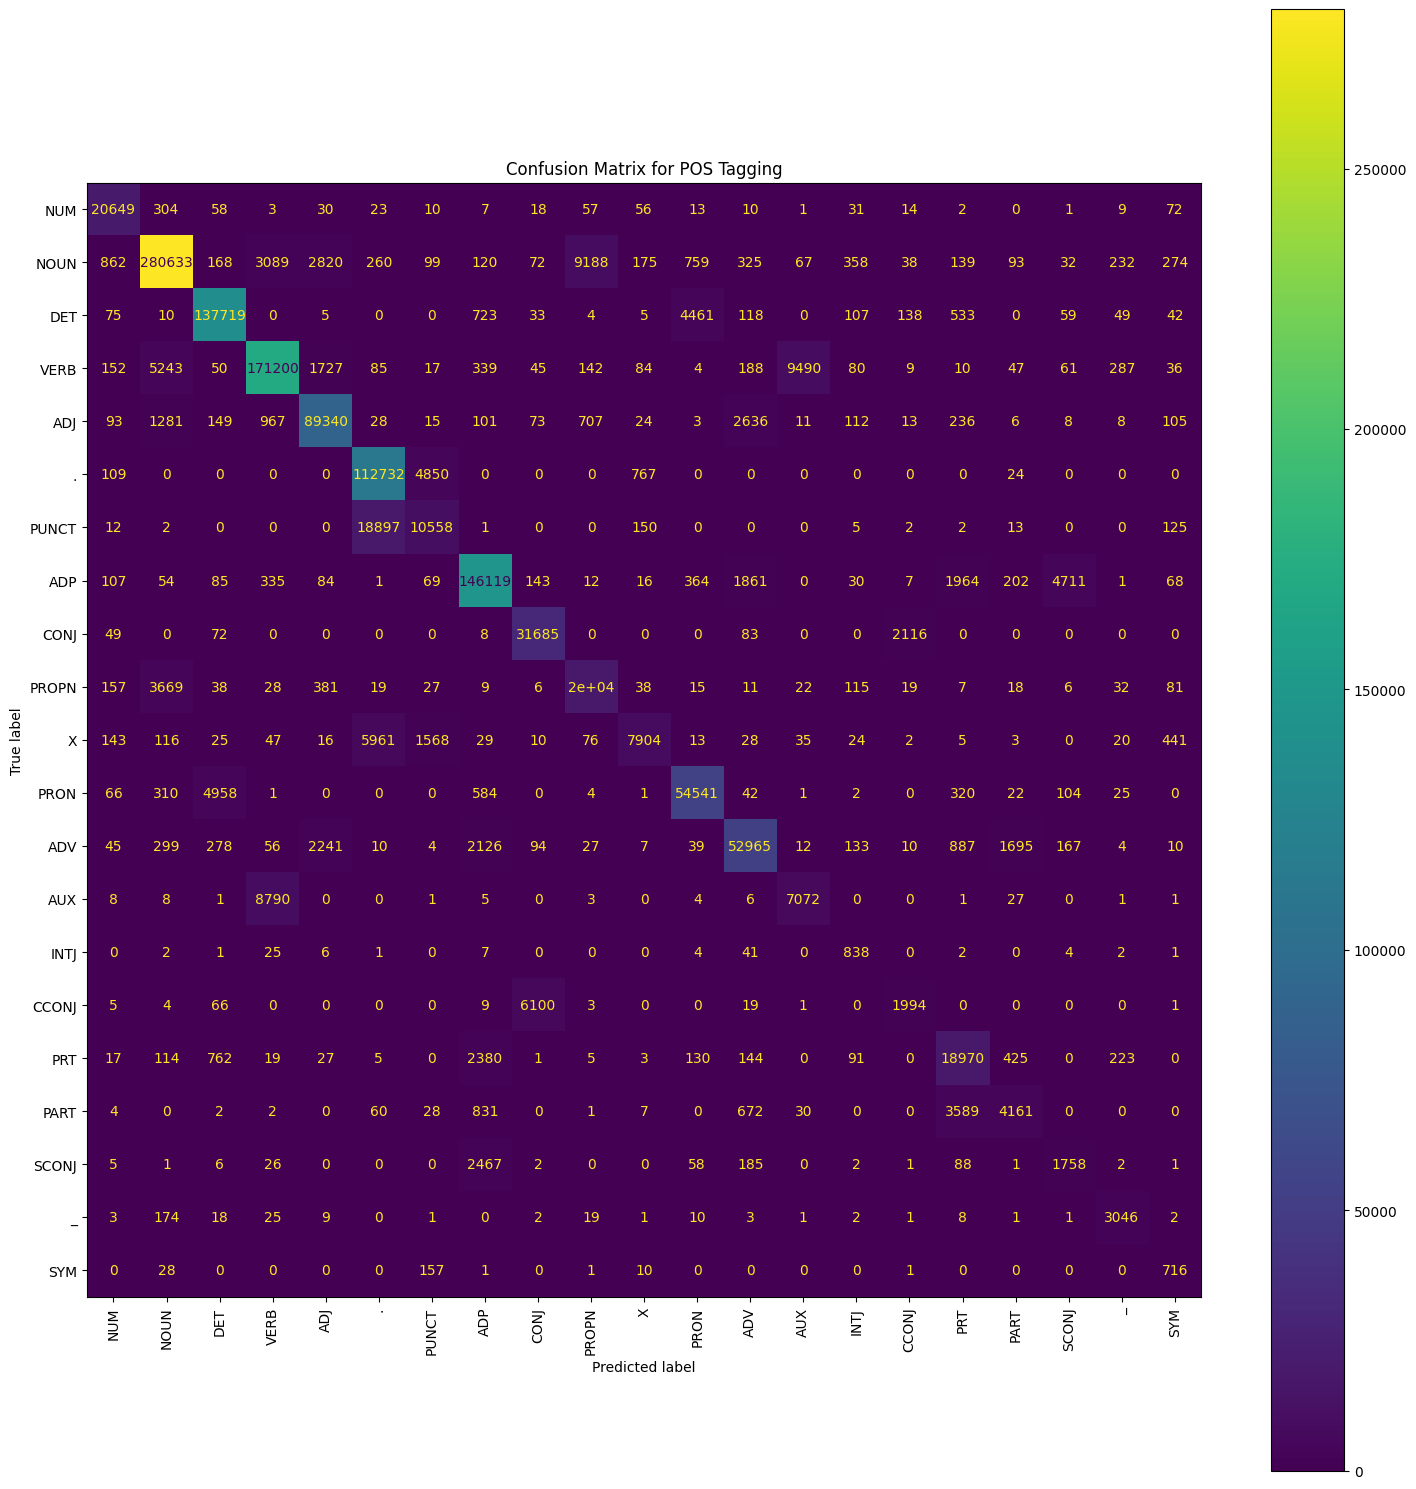

In [12]:
# Plot confusion matrix
cm = confusion_matrix(all_true_tags, all_predicted_tags, labels=all_tags)

plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_tags)
disp.plot(include_values=True, cmap='viridis', ax=plt.gca(), xticks_rotation='vertical')
plt.title('Confusion Matrix for POS Tagging')
plt.tight_layout()
plt.show()